<div class="alert alert-block alert-success" style="font-size:30px">
🔬 NESP: ThermoNet
</div>

<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>

This notebook is largely inspired by the work of Bian Li,Yucheng T. Yang,John A. Capra ,Mark B. Gerstein: [Predicting changes in protein thermodynamic stability upon point mutation with deep 3D convolutional neural networks](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008291) 
Official ThermoNet repository can be found here: https://github.com/gersteinlab/ThermoNet


I made a set of adjustments here to make it work for the NESP challenge:
1. Retrained models. Official models are trained in "unbiased" mode which is suboptimal in the context of NESP challenge. Unbiased training uses each mutation twice in the training set: forward mutation `wildetype->mutant==ddg` and the reverse mutation `mutant->wildtype==-ddg`. In case of NESP challenge only forward mutations are used in the test set. 
2. A bit of parameter finetuning. 



## How does it work?

ThermoNet trains 3D CNN with features generated from 3D structures of the wildtype and mutant proteins. This is done in 3 steps: 

1. We need to generate accurate 3D structures of mutant protein from the wildtype. In the paper authors use Rosetta "FastRelax" protocol to generate mutant PDB files. You can find this logic under `if ROSETTA` conditions. I generated all structures on my laptop and uploded them to `../input/thermonet-wildtype-relaxed/wildtypeA`.  It's close to impossible to recreate such PDB files in Kaggle boxes, because:
    * It takes a lot of time. I generated test PDBS in ~10 hours on my 16 core laptop. 
    * Rosetta comes with a license that prohibits its redistribution. So you'll have to download and acquire free academic license by yourself in order to use Rosetta.
    
2. Now once we have all PDB structures, we can generate voxel features from them. This is done with `Acellera htmd` library. Voxel features include a set of attributes packed into a grid of size (16, 16, 16). 7 used features are: `'hydrophobic', 'aromatic', 'hbond_acceptor', 'hbond_donor', 'positive_ionizable', 'negative_ionizable', 'occupancies'`. For each training sample features come from both wildtype and mutant PDBs, so the final shape of each sample is: (16, 16, 16, 14)

<img src="https://images2.imgbox.com/7c/5d/9mzuGf8N_o.png" alt="image host"/>

3. Finally a simple VGG-style CNN is used to train the regression model. An ensemble of 10 models is used to predict the score. 
    * LB: **0.4** is achived by ensemble of ThermoNet models
    * LB: **0.48** is achived by combining Thermonet output with best performing public notebooks. 

<img src="https://images2.imgbox.com/d8/b6/E88uVMfL_o.png" alt="image host"/>
    

## More Details

* **Training PDBs** are collected from the official ThermoNet repository.t Specifically I've used [Q3214](https://github.com/gersteinlab/ThermoNet/blob/master/data/datasets/Q3214.txt) dataset with relaxed PDB stored [here](https://github.com/gersteinlab/ThermoNet/tree/master/data/pdbs/Q3214_Q1744) to generate training features (`../input/thermonet-features/Q3214.npy`) 
* I generated **test PDB files** (`../input/thermonet-wildtype-relaxed/wildtypeA`) manually on my laptop by following [official instructions](https://github.com/gersteinlab/ThermoNet). Test features were then stored to `../input/thermonet-features/nesp_features.npy`


## What didn't quite work

I tried the following additional experiments to boost performance of ThermoNet, but they didn't work out:

* `GroupKFold`. Splitting folds by protein name rather than by individual mutation. Logic is the following: we get better CV estimates as our test.csv protein doesn't belong to the training set. Additionally we may get better performance, because we early stop using a more relevant criteria (validation performance on never-seen-before proteins). Performance is slightly worse on LB (0.38)
* Resnet-style models. I used scaled down models with skip connections. Performance was much worse. 
* One cycle scheduler. 
* Adding BatchNormalization/InstanceNOrmalization layers. 
* Data augmentations. I generated augmentations by randomly rotating protein at PDB->voxel stage. 10 augmentations per mutation were generated. Resulting performance was slightly worse than baseline. 

## What else could be done here?
- Additional hyperparameter optimisation
- Exploring TTA
- Trying out different resolutions of voxel grids
- Trying to include `pH` factor to training instances. `pH` is available in https://github.com/gersteinlab/ThermoNet/blob/master/data/datasets/Q3421.txt dataset. 



# Utils, imports

In [1]:
CLONE_THERMONET = True

In [2]:
import os
import sys

THERMONET_PATH = '.'
if CLONE_THERMONET:
    THERMONET_PATH = 'ThermoNet'
    !git clone https://github.com/gersteinlab/ThermoNet.git
    sys.path.append(os.path.abspath('ThermoNet/ThermoNet'))

Cloning into 'ThermoNet'...
remote: Enumerating objects: 13097, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 13097 (delta 61), reused 76 (delta 17), pack-reused 12948
Receiving objects: 100% (13097/13097), 1.05 GiB | 21.81 MiB/s, done.
Resolving deltas: 100% (5090/5090), done.
Updating files: 100% (11991/11991), done.


In [3]:
import math
import multiprocessing
import os
import sys

import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection
import tensorflow as tf
from keras import layers, callbacks
from keras import models
from keras import optimizers
from keras.saving.save import load_model
from sklearn.model_selection import GroupKFold
from tqdm import tqdm

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import plotly.express as px

MULTIPROCESSING = False
BOXSIZE = 16
VOXELSIZE = 1
EPOCHS = 200
N_FOLDS = 10
GROUP_KFOLD = False  # True CV: 39.3, False CV: 39.9
ROSETTA = False
CLEAN_OUTPUT=True
MODELS_PATH = 'models'
DEBUG=False


if DEBUG:
    EPOCHS = 10
    N_FOLDS = 3
    CLEAN_OUTPUT=False

PARAMS = {
    'conv_layer_sizes': (16, 24, 32),
    'dense_layer_size': 24,
    'dropout_rate': 0.4,#0.5
    'learning_rate': 0.0005,#0.001
    'batch_size': 8,
    'scheduler_patience': 10,
    'scheduler_factor': math.sqrt(0.1),
    'early_stopping_patience': 20,
}

try:
    import kaggle_secrets
    
    print('Running in Kaggle')
    WILDTYPE_PDB = '../input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb'
    PDB_PATH = '../input/thermonet-wildtype-relaxed'
    TRAIN_FEATURES_PATH = '../input/thermonet-features/Q3214.npy'
    TRAIN_TARGETS_PATH = 'data/datasets/Q3214_direct.csv'
    TEST_CSV='../input/novozymes-enzyme-stability-prediction/test.csv'
    TEST_FEATURES_PATH = '../input/thermonet-features/nesp_features.npy'
except Exception as ex:
    print('Running locally')
    WILDTYPE_PDB = 'nesp/thermonet/wildtypeA.pdb'
    PDB_PATH = 'nesp/thermonet/'
    TRAIN_FEATURES_PATH = 'data/datasets/Q3214.npy'
    TRAIN_TARGETS_PATH = 'data/datasets/Q3214_direct.csv'
    TEST_FEATURES_PATH = 'nesp/thermonet/nesp_features.npy'
    TEST_CSV='nesp/test.csv'


Running in Kaggle


# Generate features

In [4]:
def gen_mutations(name, df,
                  wild="VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQ""RVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGT""NAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKAL""GSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK"):
    result = []
    for _, r in df.iterrows():
        ops = Levenshtein.editops(wild, r.protein_sequence)
        assert len(ops) <= 1
        if len(ops) > 0 and ops[0][0] == 'replace':
            idx = ops[0][1]
            result.append([ops[0][0], idx + 1, wild[idx], r.protein_sequence[idx]])
        elif len(ops) == 0:
            result.append(['same', 0, '', ''])
        elif ops[0][0] == 'insert':
            assert False, "Ups"
        elif ops[0][0] == 'delete':
            idx = ops[0][1]
            result.append(['delete', idx + 1, wild[idx], '-'])
        else:
            assert False, "Ups"

    df = pd.concat([df, pd.DataFrame(data=result, columns=['op', 'idx', 'wild', 'mutant'])], axis=1)
    df['mut'] = df[['wild', 'idx', 'mutant']].astype(str).apply(lambda v: ''.join(v), axis=1)
    df['name'] = name
    return df


df_test = gen_mutations('wildtypeA', pd.read_csv(TEST_CSV))
df_test

,seq_id,protein_sequence,pH,data_source,op,idx,wild,mutant,mut,name
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,E,L17E,wildtypeA
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,K,L17K,wildtypeA
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,delete,17,L,-,L17-,wildtypeA
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,C,K18C,wildtypeA
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,F,K18F,wildtypeA
...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,I,A16I,wildtypeA
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,L,A16L,wildtypeA
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,N,A16N,wildtypeA
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,P,A16P,wildtypeA


In [5]:
df_train = pd.read_csv(f'{THERMONET_PATH}/{TRAIN_TARGETS_PATH}')
df_train

,pdb_id,position,wild_type,mutant,ddg
0,1otrB,34,E,A,-0.07
1,1a5eA,121,L,R,-0.66
2,1rtbA,4,A,S,0.47
3,4lyzA,102,G,R,-0.38
4,1thqA,157,M,A,0.77
...,...,...,...,...,...
3209,2lzmA,42,A,K,3.70
3210,1yeaA,76,P,G,1.20
3211,1stnA,104,V,T,2.50
3212,2lzmA,71,V,A,1.50


In [6]:
def gen_features(pdb_chain, pos, wt, mt):
    from utils import pdb_utils
    
    pdb_dir = os.path.abspath(PDB_PATH)
    wt_pdb_path = os.path.join(pdb_dir, pdb_chain, pdb_chain + '_relaxed.pdb')
    features_wt = pdb_utils.compute_voxel_features(pos, wt_pdb_path, boxsize=BOXSIZE,
                                                   voxelsize=VOXELSIZE)
    features_wt = np.delete(features_wt, obj=6, axis=0)  # removing 0 'metallic' layer

    mt_pdb_path = os.path.join(pdb_dir, pdb_chain, pdb_chain + '_' + wt + str(pos) + mt + '_relaxed.pdb')
    features_mt = pdb_utils.compute_voxel_features(pos, mt_pdb_path, boxsize=BOXSIZE,
                                                   voxelsize=VOXELSIZE)
    features_mt = np.delete(features_mt, obj=6, axis=0)  # removing 0 'metallic' layer
    features_combined = np.concatenate((features_wt, features_mt), axis=0)
    return features_combined


def thermonet_features(df):
    install_htmd()
    os.environ['HTMD_NONINTERACTIVE'] = '1'
    if MULTIPROCESSING:
        with multiprocessing.Pool() as pool:
            thermonet_features = pool.starmap(gen_features,
                                              [[r['name'], r.idx, r.wild, r.mutant] for _, r in df.iterrows()])
    else:
        thermonet_features = [gen_features(r['name'], r.idx, r.wild, r.mutant) for _, r in
                              tqdm(df.iterrows(), total=len(df))]
    thermonet_features = np.array(thermonet_features)
    return thermonet_features


def install_htmd():
    try:
        os.environ["HTMD_NONINTERACTIVE"] = "1"
        import htmd
        print('htmd already installed')
    except Exception as ex:
        !conda install -q -y -c acellera  htmd==2.0.5
        !mkdir -p /root/.htmd/.registered-htmd
        !echo '{"name":"your name","email":"youremail@gmail.com","institution":".","city":"London","country":"UK","product":"htmd","code":342455931}' > /root/.htmd/.registered-htmd/registration

if not os.path.exists(TRAIN_FEATURES_PATH):    
    np.save(thermonet_features(df_train.rename(columns={'pdb_id': 'name', 'position': 'idx', 'wild_type': 'wild'})), 'train_features.npy')
    TRAIN_FEATURES_PATH = 'train_features.npy'

In [7]:
X = np.load(TRAIN_FEATURES_PATH)
X = np.moveaxis(X, 1, -1)
X.shape

(3214, 16, 16, 16, 14)

## Plotting voxel representation of features

In the following plots we use 3D scatterplot to demonstrate training samples. 
Specifically we plot `occupancy` feature that represents probability that certain voxel is occpupied by an atom.
Recall that each training/test sample uses a combination of wildetype+mutant features. So we use the following color-coding:
* blue color represents voxels that are occupied in both wildtype and mutant structures 
* red color represents voxels that are occupied only in the mutant structure
* green color represents voxels that are occupied only in the wildtype structure

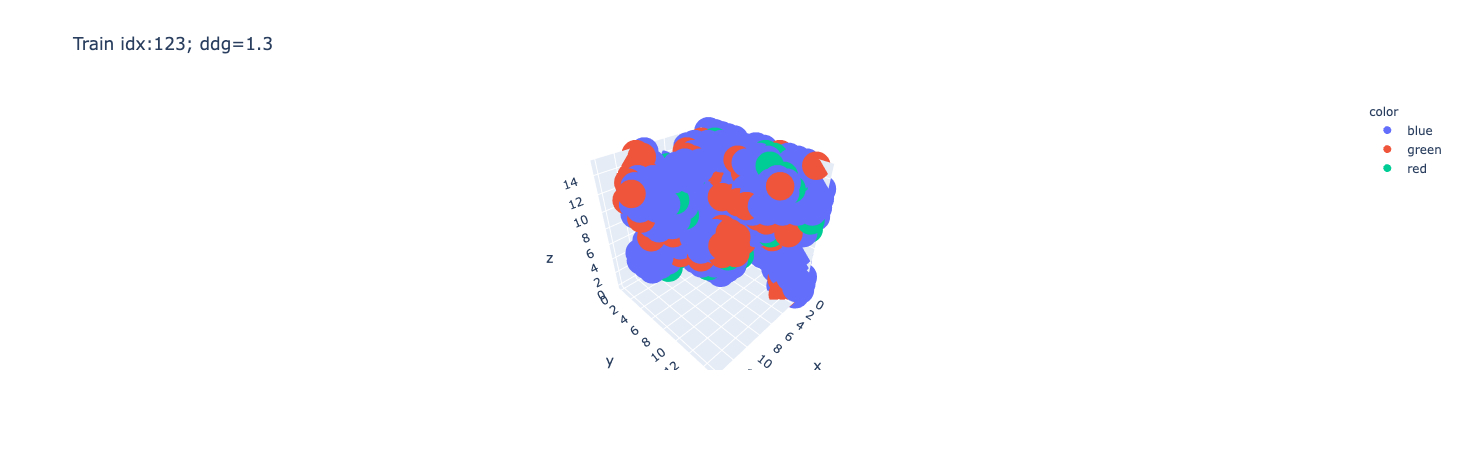

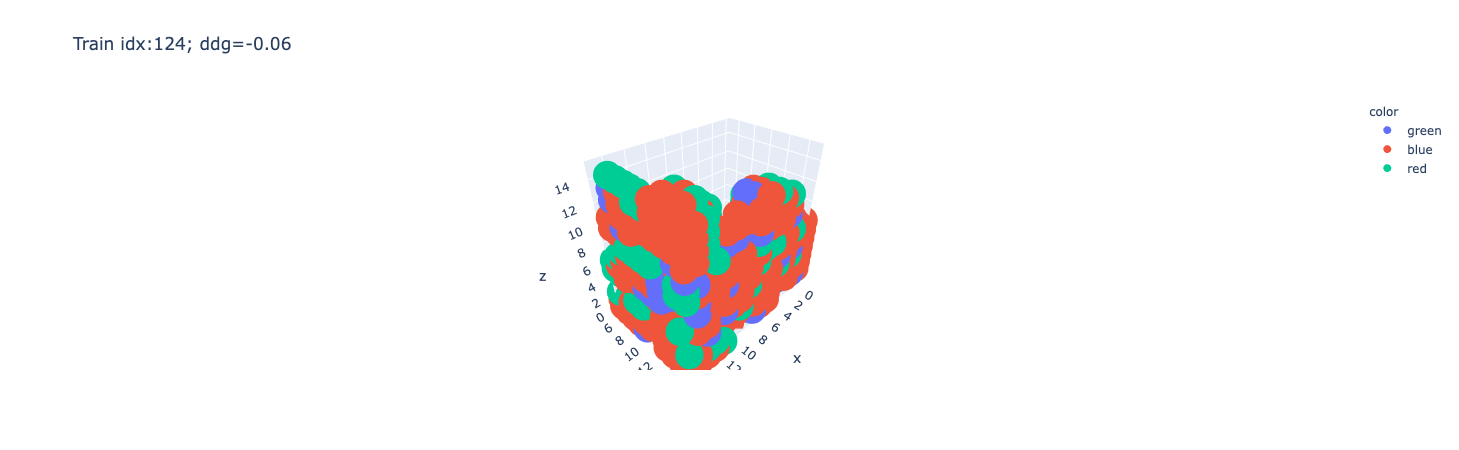

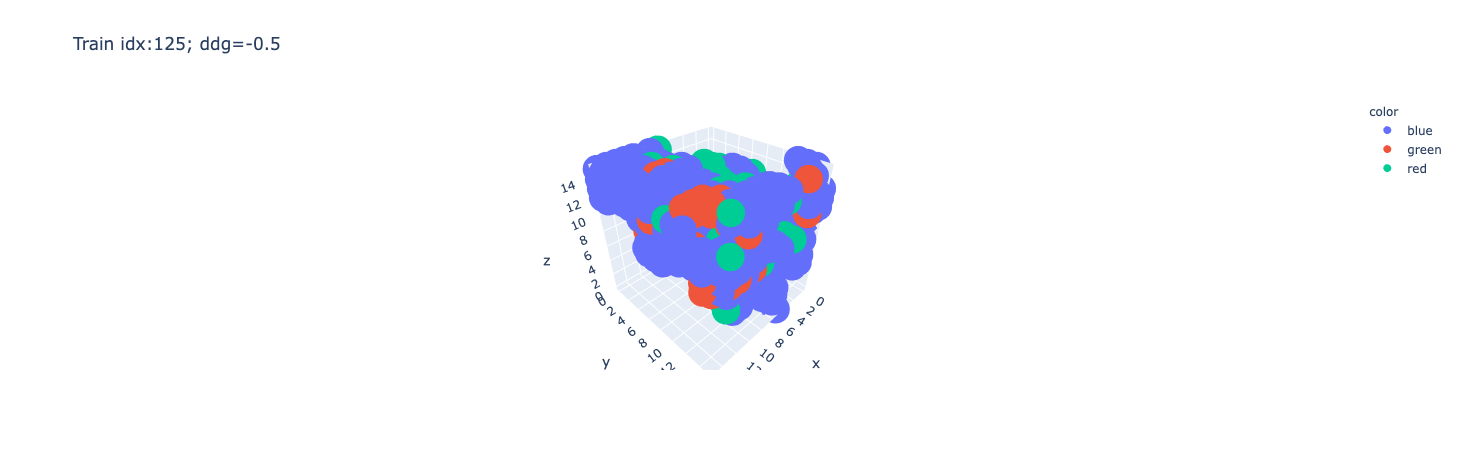

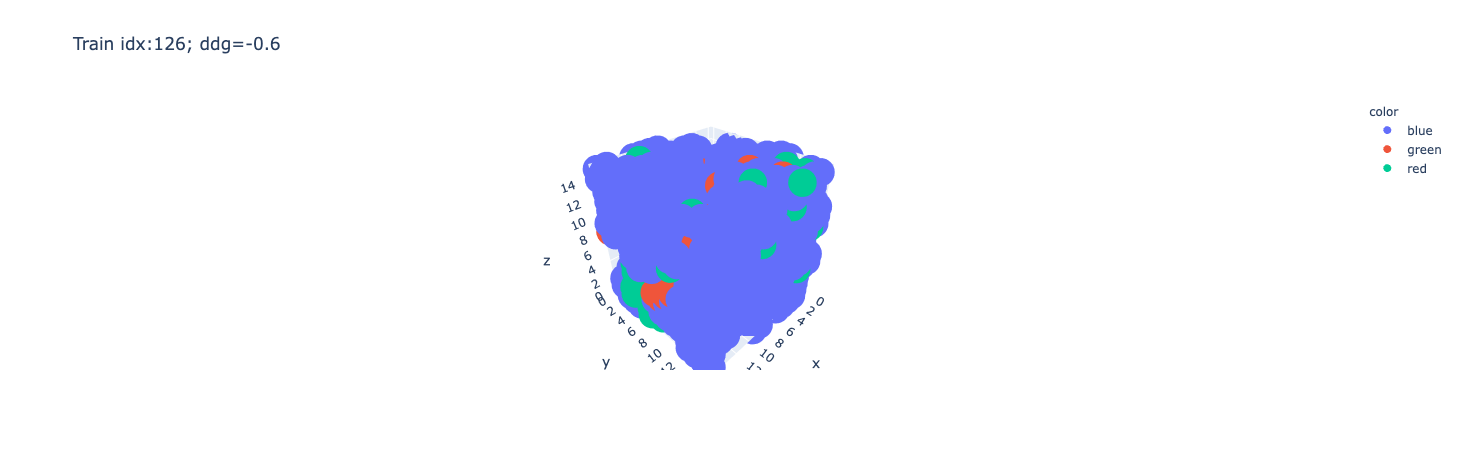

In [8]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

def plot_voxels():
    for i in [123, 124, 125, 126]:
        df = pd.DataFrame([(x, y1, z) for x in range(16) for y1 in range(16) for z in range(16)], columns=['x', 'y', 'z'])
        df['occupancy1'] = X[i, :, :, :, 6].flatten() > 0.9
        df['occupancy2'] = X[i, :, :, :, 13].flatten() > 0.9
        df.loc[df.occupancy1 | df.occupancy2, 'color'] = 'blue'
        df.loc[~df.occupancy1 & df.occupancy2, 'color'] = 'red'
        df.loc[df.occupancy1 & ~df.occupancy2, 'color'] = 'green'
        ddg = df_train.ddg[i]
        fig = px.scatter_3d(df.dropna(), x='x', y='y', z='z', color='color', title=f"Train idx:{i}; ddg={ddg}")
        fig.show()

plot_voxels()

# Train

In [9]:
pdb_ids = df_train.pdb_id
y = df_train.ddg

In [10]:
def gen_model(params):
    def build_model(params):
        conv_layer_sizes = params['conv_layer_sizes']
        dense_layer_size = params['dense_layer_size']
        dropout_rate = params['dropout_rate']
        model = models.Sequential()
        model.add(layers.Conv3D(filters=conv_layer_sizes[0], kernel_size=(3, 3, 3), input_shape=(16, 16, 16, 14)))
        model.add(layers.Activation(activation='relu'))

        for ls in conv_layer_sizes[1:]:
            model.add(layers.Conv3D(filters=ls, kernel_size=(3, 3, 3)))
            model.add(layers.Activation(activation='relu'))

        model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(layers.Flatten())

        model.add(layers.Dropout(rate=dropout_rate))
        model.add(layers.Dense(units=dense_layer_size, activation='relu'))
        model.add(layers.Dropout(rate=dropout_rate))
        model.add(layers.Dense(units=1))
        return model

    model = build_model(params)
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(
        learning_rate=params['learning_rate'],
        beta_1=0.9,
        beta_2=0.999,
        amsgrad=False
    ), metrics=['mae'])
    return model


def train_model(X_train, y_train, X_val, y_val, params, path):
    model = gen_model(params)
    scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=params['scheduler_factor'],
        patience=params['scheduler_patience'],
        verbose=0,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=1e-5,
    )

    checkpoint = callbacks.ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=params['early_stopping_patience'])
    result = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                       epochs=EPOCHS, batch_size=params['batch_size'], verbose=1, callbacks=[scheduler, checkpoint, early_stopping])
    return load_model(path), result


!mkdir -p models
kfold = GroupKFold(N_FOLDS)
thermonet_models = []
val_losses = []
if GROUP_KFOLD:
    groups = pdb_ids
else:
    groups = range(len(pdb_ids))

for fold, (train_idx, val_idx) in enumerate(tqdm(kfold.split(X, y, groups=groups), total=N_FOLDS, desc="Folds")):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    path = f'{MODELS_PATH}/model{fold}.h5'
    model, result = train_model(X_train, y_train, X_val, y_val, PARAMS, path)
    thermonet_models.append(model)
    val_losses.append(result.history['val_loss'])

Folds:   0%|          | 0/10 [00:00<?, ?it/s]2022-10-24 10:52:06.175490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 10:52:06.179479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 10:52:06.180216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 10:52:06.182420: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, r

Epoch 1/200


2022-10-24 10:52:13.001129: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


360/362 [============================>.] - ETA: 0s - loss: 4.1698 - mae: 1.4049

2022-10-24 10:52:21.162362: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 73859072 exceeds 10% of free system memory.
2022-10-24 10:52:21.264980: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 73859072 exceeds 10% of free system memory.


362/362 [==============================] - 10s 7ms/step - loss: 4.1768 - mae: 1.4057 - val_loss: 3.5297 - val_mae: 1.3429

Epoch 00001: val_loss improved from inf to 3.52971, saving model to models/model0.h5
Epoch 2/200
362/362 [==============================] - 2s 6ms/step - loss: 3.9965 - mae: 1.3545 - val_loss: 3.0767 - val_mae: 1.2794

Epoch 00002: val_loss improved from 3.52971 to 3.07670, saving model to models/model0.h5
Epoch 3/200
362/362 [==============================] - 2s 6ms/step - loss: 3.6276 - mae: 1.2797 - val_loss: 2.7166 - val_mae: 1.1938

Epoch 00003: val_loss improved from 3.07670 to 2.71659, saving model to models/model0.h5
Epoch 4/200
362/362 [==============================] - 2s 6ms/step - loss: 3.4325 - mae: 1.2492 - val_loss: 2.7917 - val_mae: 1.2302

Epoch 00004: val_loss did not improve from 2.71659
Epoch 5/200
362/362 [==============================] - 2s 6ms/step - loss: 3.3807 - mae: 1.2461 - val_loss: 2.6759 - val_mae: 1.1699

Epoch 00005: val_loss impro

Folds:  10%|█         | 1/10 [03:25<30:50, 205.62s/it]2022-10-24 10:55:32.356571: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 663355392 exceeds 10% of free system memory.


Epoch 1/200
362/362 [==============================] - 3s 7ms/step - loss: 4.0497 - mae: 1.4029 - val_loss: 4.2927 - val_mae: 1.3751

Epoch 00001: val_loss improved from inf to 4.29267, saving model to models/model1.h5
Epoch 2/200
362/362 [==============================] - 2s 7ms/step - loss: 3.8936 - mae: 1.3499 - val_loss: 4.2786 - val_mae: 1.3640

Epoch 00002: val_loss improved from 4.29267 to 4.27863, saving model to models/model1.h5
Epoch 3/200
362/362 [==============================] - 2s 5ms/step - loss: 3.7274 - mae: 1.3287 - val_loss: 3.9363 - val_mae: 1.3203

Epoch 00003: val_loss improved from 4.27863 to 3.93628, saving model to models/model1.h5
Epoch 4/200
362/362 [==============================] - 2s 5ms/step - loss: 3.3513 - mae: 1.2592 - val_loss: 3.5458 - val_mae: 1.3031

Epoch 00004: val_loss improved from 3.93628 to 3.54577, saving model to models/model1.h5
Epoch 5/200
362/362 [==============================] - 2s 5ms/step - loss: 3.2382 - mae: 1.2278 - val_loss: 3.66

Folds:  20%|██        | 2/10 [06:41<26:40, 200.04s/it]

Epoch 1/200
362/362 [==============================] - 3s 6ms/step - loss: 4.0795 - mae: 1.3936 - val_loss: 3.9385 - val_mae: 1.3758

Epoch 00001: val_loss improved from inf to 3.93852, saving model to models/model2.h5
Epoch 2/200
362/362 [==============================] - 2s 5ms/step - loss: 3.8330 - mae: 1.3460 - val_loss: 3.8071 - val_mae: 1.3399

Epoch 00002: val_loss improved from 3.93852 to 3.80705, saving model to models/model2.h5
Epoch 3/200
362/362 [==============================] - 2s 6ms/step - loss: 3.5398 - mae: 1.2736 - val_loss: 3.4973 - val_mae: 1.2567

Epoch 00003: val_loss improved from 3.80705 to 3.49730, saving model to models/model2.h5
Epoch 4/200
362/362 [==============================] - 2s 6ms/step - loss: 3.3333 - mae: 1.2359 - val_loss: 3.5321 - val_mae: 1.2466

Epoch 00004: val_loss did not improve from 3.49730
Epoch 5/200
362/362 [==============================] - 2s 5ms/step - loss: 3.1689 - mae: 1.2020 - val_loss: 3.3798 - val_mae: 1.1910

Epoch 00005: val

Folds:  30%|███       | 3/10 [08:26<18:14, 156.42s/it]

Epoch 1/200
362/362 [==============================] - 3s 7ms/step - loss: 4.3016 - mae: 1.4394 - val_loss: 2.8411 - val_mae: 1.2142

Epoch 00001: val_loss improved from inf to 2.84107, saving model to models/model3.h5
Epoch 2/200
362/362 [==============================] - 2s 5ms/step - loss: 3.9583 - mae: 1.3555 - val_loss: 2.3639 - val_mae: 1.1218

Epoch 00002: val_loss improved from 2.84107 to 2.36389, saving model to models/model3.h5
Epoch 3/200
362/362 [==============================] - 2s 5ms/step - loss: 3.6237 - mae: 1.3040 - val_loss: 2.1652 - val_mae: 1.0617

Epoch 00003: val_loss improved from 2.36389 to 2.16523, saving model to models/model3.h5
Epoch 4/200
362/362 [==============================] - 2s 5ms/step - loss: 3.5425 - mae: 1.2806 - val_loss: 2.4243 - val_mae: 1.1099

Epoch 00004: val_loss did not improve from 2.16523
Epoch 5/200
362/362 [==============================] - 2s 5ms/step - loss: 3.2195 - mae: 1.2111 - val_loss: 2.2907 - val_mae: 1.0696

Epoch 00005: val

Folds:  40%|████      | 4/10 [10:04<13:21, 133.62s/it]

Epoch 1/200
362/362 [==============================] - 3s 7ms/step - loss: 4.1866 - mae: 1.4098 - val_loss: 3.0225 - val_mae: 1.3079

Epoch 00001: val_loss improved from inf to 3.02247, saving model to models/model4.h5
Epoch 2/200
362/362 [==============================] - 2s 6ms/step - loss: 3.9053 - mae: 1.3566 - val_loss: 2.9354 - val_mae: 1.2348

Epoch 00002: val_loss improved from 3.02247 to 2.93541, saving model to models/model4.h5
Epoch 3/200
362/362 [==============================] - 2s 6ms/step - loss: 3.6600 - mae: 1.2960 - val_loss: 2.8174 - val_mae: 1.2125

Epoch 00003: val_loss improved from 2.93541 to 2.81742, saving model to models/model4.h5
Epoch 4/200
362/362 [==============================] - 2s 6ms/step - loss: 3.4226 - mae: 1.2461 - val_loss: 2.7005 - val_mae: 1.1761

Epoch 00004: val_loss improved from 2.81742 to 2.70050, saving model to models/model4.h5
Epoch 5/200
362/362 [==============================] - 2s 5ms/step - loss: 3.2129 - mae: 1.2139 - val_loss: 2.40

Folds:  50%|█████     | 5/10 [11:50<10:17, 123.53s/it]

Epoch 1/200
362/362 [==============================] - 3s 7ms/step - loss: 3.9984 - mae: 1.3918 - val_loss: 4.8188 - val_mae: 1.4274

Epoch 00001: val_loss improved from inf to 4.81878, saving model to models/model5.h5
Epoch 2/200
362/362 [==============================] - 2s 5ms/step - loss: 3.8307 - mae: 1.3537 - val_loss: 4.9510 - val_mae: 1.4279

Epoch 00002: val_loss did not improve from 4.81878
Epoch 3/200
362/362 [==============================] - 2s 6ms/step - loss: 3.4816 - mae: 1.2789 - val_loss: 4.5474 - val_mae: 1.3640

Epoch 00003: val_loss improved from 4.81878 to 4.54736, saving model to models/model5.h5
Epoch 4/200
362/362 [==============================] - 2s 6ms/step - loss: 3.3121 - mae: 1.2439 - val_loss: 4.5060 - val_mae: 1.3356

Epoch 00004: val_loss improved from 4.54736 to 4.50598, saving model to models/model5.h5
Epoch 5/200
362/362 [==============================] - 2s 5ms/step - loss: 3.1497 - mae: 1.2133 - val_loss: 4.5740 - val_mae: 1.3642

Epoch 00005: val

Folds:  60%|██████    | 6/10 [14:15<08:43, 130.94s/it]

Epoch 1/200
362/362 [==============================] - 3s 6ms/step - loss: 4.2814 - mae: 1.4263 - val_loss: 3.1514 - val_mae: 1.2839

Epoch 00001: val_loss improved from inf to 3.15141, saving model to models/model6.h5
Epoch 2/200
362/362 [==============================] - 2s 6ms/step - loss: 4.0044 - mae: 1.3613 - val_loss: 2.6486 - val_mae: 1.2196

Epoch 00002: val_loss improved from 3.15141 to 2.64862, saving model to models/model6.h5
Epoch 3/200
362/362 [==============================] - 2s 5ms/step - loss: 3.6115 - mae: 1.2966 - val_loss: 2.6474 - val_mae: 1.1910

Epoch 00003: val_loss improved from 2.64862 to 2.64735, saving model to models/model6.h5
Epoch 4/200
362/362 [==============================] - 2s 6ms/step - loss: 3.3723 - mae: 1.2386 - val_loss: 2.3701 - val_mae: 1.1329

Epoch 00004: val_loss improved from 2.64735 to 2.37010, saving model to models/model6.h5
Epoch 5/200
362/362 [==============================] - 2s 5ms/step - loss: 3.2367 - mae: 1.2235 - val_loss: 2.23

Folds:  70%|███████   | 7/10 [16:41<06:46, 135.61s/it]

Epoch 1/200
362/362 [==============================] - 4s 7ms/step - loss: 3.9264 - mae: 1.3737 - val_loss: 4.5427 - val_mae: 1.3877

Epoch 00001: val_loss improved from inf to 4.54268, saving model to models/model7.h5
Epoch 2/200
362/362 [==============================] - 2s 5ms/step - loss: 3.8000 - mae: 1.3505 - val_loss: 4.4486 - val_mae: 1.3524

Epoch 00002: val_loss improved from 4.54268 to 4.44859, saving model to models/model7.h5
Epoch 3/200
362/362 [==============================] - 2s 5ms/step - loss: 3.4864 - mae: 1.2892 - val_loss: 4.1330 - val_mae: 1.2875

Epoch 00003: val_loss improved from 4.44859 to 4.13302, saving model to models/model7.h5
Epoch 4/200
362/362 [==============================] - 2s 6ms/step - loss: 3.2984 - mae: 1.2391 - val_loss: 3.9092 - val_mae: 1.2468

Epoch 00004: val_loss improved from 4.13302 to 3.90919, saving model to models/model7.h5
Epoch 5/200
362/362 [==============================] - 2s 5ms/step - loss: 3.1788 - mae: 1.2182 - val_loss: 3.58

Folds:  80%|████████  | 8/10 [20:07<05:16, 158.12s/it]

Epoch 1/200
362/362 [==============================] - 3s 6ms/step - loss: 3.9502 - mae: 1.3918 - val_loss: 4.9942 - val_mae: 1.4061

Epoch 00001: val_loss improved from inf to 4.99421, saving model to models/model8.h5
Epoch 2/200
362/362 [==============================] - 2s 6ms/step - loss: 3.7049 - mae: 1.3435 - val_loss: 4.8690 - val_mae: 1.4533

Epoch 00002: val_loss improved from 4.99421 to 4.86901, saving model to models/model8.h5
Epoch 3/200
362/362 [==============================] - 2s 6ms/step - loss: 3.5216 - mae: 1.2978 - val_loss: 4.6655 - val_mae: 1.4208

Epoch 00003: val_loss improved from 4.86901 to 4.66548, saving model to models/model8.h5
Epoch 4/200
362/362 [==============================] - 2s 6ms/step - loss: 3.2417 - mae: 1.2418 - val_loss: 4.5693 - val_mae: 1.3220

Epoch 00004: val_loss improved from 4.66548 to 4.56935, saving model to models/model8.h5
Epoch 5/200
362/362 [==============================] - 2s 5ms/step - loss: 3.0497 - mae: 1.2060 - val_loss: 4.34

Folds:  90%|█████████ | 9/10 [22:00<02:24, 144.14s/it]

Epoch 1/200
362/362 [==============================] - 3s 7ms/step - loss: 4.1395 - mae: 1.4053 - val_loss: 3.2533 - val_mae: 1.2625

Epoch 00001: val_loss improved from inf to 3.25331, saving model to models/model9.h5
Epoch 2/200
362/362 [==============================] - 2s 6ms/step - loss: 3.9309 - mae: 1.3492 - val_loss: 3.0130 - val_mae: 1.2233

Epoch 00002: val_loss improved from 3.25331 to 3.01299, saving model to models/model9.h5
Epoch 3/200
362/362 [==============================] - 2s 5ms/step - loss: 3.6371 - mae: 1.3097 - val_loss: 2.8412 - val_mae: 1.1574

Epoch 00003: val_loss improved from 3.01299 to 2.84124, saving model to models/model9.h5
Epoch 4/200
362/362 [==============================] - 2s 5ms/step - loss: 3.3369 - mae: 1.2365 - val_loss: 2.9545 - val_mae: 1.2051

Epoch 00004: val_loss did not improve from 2.84124
Epoch 5/200
362/362 [==============================] - 2s 5ms/step - loss: 3.1611 - mae: 1.2038 - val_loss: 3.1976 - val_mae: 1.2838

Epoch 00005: val

Folds: 100%|██████████| 10/10 [23:25<00:00, 140.55s/it]


Text(0.5, 1.0, 'CV MSE loss: 2.564')

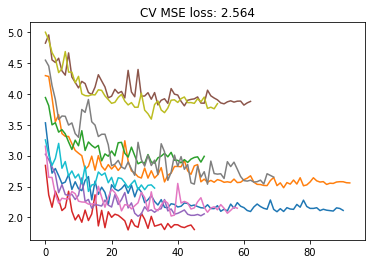

In [11]:
cv = 0.
for l in val_losses:
    plt.plot(l)
    cv += np.min(l)

plt.title(f"CV MSE loss: {cv / len(val_losses):.03f}")

# Submission [LB:0.4]

In [12]:
if ROSETTA:
    !relax.static.linuxgccrelease -in:file:s $WILDTYPE_PDB -relax:constrain_relax_to_start_coords -out:suffix _relaxed -out:no_nstruct_label -relax:ramp_constraints false
    df_test.query('op == "replace"')[['name', 'idx', 'wild', 'mutant']].to_csv('wildtypeA_mutations.txt', header=False, sep=' ', index=False)
    !python $THERMONET_PATH/rosetta_relax.py --rosetta-bin relax.static.linuxgccrelease -l wildtypeA_mutations.txt --base-dir .

In [13]:
import glob
thermonet_models = [load_model(f) for f in glob.glob(f'{MODELS_PATH}/model*.h5')]

In [14]:
if not os.path.exists(TEST_FEATURES_PATH):    
    np.save(thermonet_features(df_test.query('op == "replace"')), 'test_features.npy')
    TEST_FEATURES_PATH = 'test_features.npy'

In [15]:
test_features = np.load(TEST_FEATURES_PATH)
test_features = np.moveaxis(test_features, 1, -1)
test_features.shape

(2335, 16, 16, 16, 14)

In [16]:
test_ddg = np.stack([model.predict(test_features) for model in thermonet_models])
test_ddg = np.mean(test_ddg, axis=0).flatten()
test_ddg

array([0.6187552 , 0.32003933, 1.181723  , ..., 0.31414732, 0.08170678,
       0.33486062], dtype=float32)

In [17]:
df_test.loc[df_test.op == 'replace', 'ddg'] = -test_ddg

In [18]:
df_test.loc[df_test['op'] == "delete", 'ddg'] = df_test[df_test["op"]=="replace"]["ddg"].quantile(q=0.25)
df_test.loc[df_test['op'] == "same", 'ddg'] = 0.

In [19]:
df_test

,seq_id,protein_sequence,pH,data_source,op,idx,wild,mutant,mut,name,ddg
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,E,L17E,wildtypeA,-0.618755
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,17,L,K,L17K,wildtypeA,-0.320039
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,delete,17,L,-,L17-,wildtypeA,-1.307054
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,C,K18C,wildtypeA,-1.181723
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,18,K,F,K18F,wildtypeA,-1.351516
...,...,...,...,...,...,...,...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,I,A16I,wildtypeA,-0.136645
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,L,A16L,wildtypeA,-0.129934
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,N,A16N,wildtypeA,-0.314147
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,replace,16,A,P,A16P,wildtypeA,-0.081707


In [20]:
df_test.rename(columns={'ddg': 'tm'})[['seq_id', 'tm']].to_csv('submission.csv', index=False)

In [21]:
!head submission.csv

seq_id,tm
31390,-0.6187552
31391,-0.32003933
31392,-1.3070538
31393,-1.181723
31394,-1.3515155
31395,-1.7461401
31396,-1.2890098
31397,-0.86258507
31398,-0.47569633


# Ensemble LB:0.48

In [22]:
import pandas as pd
from scipy.stats import rankdata

sub1 = pd.read_csv('../input/plldt-ddg-demask-sasa/deepddg-ddg.csv')
sub2 = pd.read_csv('../input/novozymes-in-r-blosum-deepddg-demask/submission.csv')
sub3 = pd.read_csv('../input/novo-esp-eli5-performant-approaches-lb-0-451/submission.csv')
sub4 = pd.read_csv('../input/nesp-alphafold-getarea-exploration/submission.csv')
sub5 = pd.read_csv('submission.csv')

sub1['tm'] = rankdata(sub1['tm'].values) + rankdata(sub2['tm'].values) + rankdata(sub3['tm'].values) + rankdata(sub4['tm'].values)  + rankdata(sub5['tm'].values)
sub1.to_csv('submission_ensemble.csv',index=False)
!head submission_ensemble.csv

seq_id,tm
31390,9061.0
31391,9955.0
31392,6081.0
31393,6696.5
31394,6758.5
31395,7222.0
31396,7910.0
31397,8394.5
31398,10368.5


In [23]:
if CLEAN_OUTPUT:
    !rm -rf ThermoNet


<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>
